<a href="https://colab.research.google.com/github/vlavrent/NLP_Dash/blob/main/Topic_Modelling_for_English_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install bertopic

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stop = stopwords.words('english')
class English_Preprocess():
    def __init__(self,data_path,comment_col,normalised_col):
        self.path = data_path
        self.data = pd.read_csv(self.path,index_col=0)
        self.col = comment_col
        self.norm_col = normalised_col


    # Read data
    def read_data(self):
        return pd.read_csv(self.path,index_col=0)

    # Remove emoji
    def remove_emojis(self,text):
      emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

      return emoji_pattern.sub(r'', text)

    # Remove emoji per row
    def convert_emoji(self):
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x:  self.remove_emojis(x))
        self.data = self.data.reset_index()

    # Remove null rows
    def remove_null(self):
        self.data = self.data[self.data[self.col]!='\\N']
        self.data = self.data.dropna()

    # Add space between numbers and text
    def create_number_string_space(self):
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub('\d{5,}', r' ', x))
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub('i x e', r' ', x))
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub('(\d+(\.\d+)?)', r' \1 ', x))


    # Lowercase text
    def lower_data(self):
        self.data[self.norm_col] = self.data[self.col].str.lower()

    # Remove Punctuation
    def remove_punctuation(self):
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    def replace_words_characters(self,x):

        x = re.sub("don’t|dont|don't","do not",x)
        x = re.sub("doesn’t|doesnt","does not",x)
        x = re.sub("didn’t|didnt","did not",x)
        x = re.sub("i'm|i’m","i am",x)
        x = re.sub("fair","fare",x)
        x = re.sub("\\\\n"," ",x)

        return x

   # Replace words
    def replace_values(self):
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: self.replace_words_characters(x))

    # Remove two or more spaces
    def remove_multiple_space(self):
        #self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub(' +', ' ',x))

        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: " ".join(x.split()))

    # Dropna
    def empty_string(self):
      self.data = self.data[self.data[self.norm_col]!='']

    # Remove Punctuation
    def remove_punctuation(self):
        self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    # Remove Stopwords
    def remove_stopwords(self):
      self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Remove 3 character words
    def filter_char(self):
      self.data[self.norm_col] = self.data[self.norm_col].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
      #self.data = self.data[self.data['char_bool']!=True]


    def return_data(self):

        self.remove_null()

        self.lower_data()

        self.convert_emoji()

        self.replace_values()

        self.create_number_string_space()

        self.remove_punctuation()

        self.remove_multiple_space()

        self.remove_stopwords()

        self.empty_string()

        return self.data.reset_index()

# Split train and label
def split_data(data):
  X = data[['normalised']]
  y = data[['New_Topic']]
  return X,y

# Define Encoder
def encoder(train):
  le = LabelEncoder().fit(train)
  return le

# Label Encoder
def label_encode_decode(train,predict,action,le):

  if action=='encode':
    return le.transform(train)
  elif action=='decode':
    return le.inverse_transform(predict)



In [ ]:
clean_data = English_Preprocess('/content/drive/My Drive/NLP Dash/train_test/courier_csat_train_set_2.csv','csat_comment','normalised')
data  = clean_data.return_data()

X,y = split_data(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train['normalised'])
X_test = vectorizer.transform(X_test['normalised'])



<Axes: xlabel='New_Topic'>

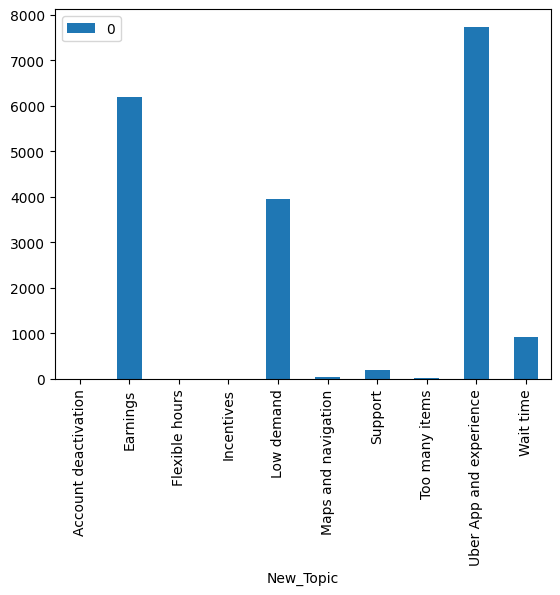

In [ ]:
# Plot the class distribution
pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)], axis=1).groupby(['New_Topic']).count().reset_index().plot(x='New_Topic',y=0,kind='bar')

<Axes: xlabel='New_Topic'>

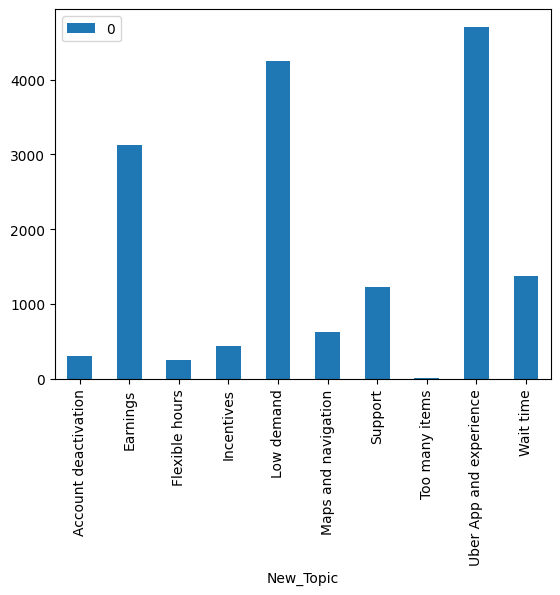

In [ ]:
# Class distribution
unique, counts = np.unique(y_train, return_counts=True)

# Choose oversampling %
oversampling_strategy = {
    unique[0]: int(counts[0] * 6),
    unique[1]: int(counts[1] ),
    unique[2]: int(counts[2] * 4),
    unique[3]: int(counts[3] * 4),
    unique[4]: int(counts[4] ),
    unique[5]: int(counts[5] * 4),
    unique[6]: int(counts[6] * 4),
    unique[7]: int(counts[7] * 10),
    unique[8]: int(counts[8] ),
    unique[9]: int(counts[9] * 4)

}

# Choose undersampling %
undersample_strategy = {
    unique[0]: int(counts[0] ),
    unique[1]: int(counts[1] *0.5 ),
    unique[2]: int(counts[2] ),
    unique[3]: int(counts[3] ),
    unique[4]: int(counts[4] *0.5 ),
    unique[5]: int(counts[5] ),
    unique[6]: int(counts[6] ),
    unique[7]: int(counts[7] ),
    unique[8]: int(counts[8] *0.5 ),
    unique[9]: int(counts[9] )
}

# Set up the undersampling method
smote = SMOTE(sampling_strategy=oversampling_strategy)

# OveResample the dataset
X_train, y_train = smote.fit_resample(X_train, y_train)

# Undersample the dataset
undersample_ratio = 0.5
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy)
X_train, y_train = undersampler.fit_resample(X_train, y_train)


# Plot the class distribution
pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)], axis=1).groupby(['New_Topic']).count().reset_index().plot(x='New_Topic',y=0,kind='bar')



<h1>Label Encode</h1>

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# fit model no training data
model = XGBClassifier(objective='multi:softprob',num_class=10)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       136
           1       0.84      0.83      0.83      3076
           2       0.74      0.66      0.70       111
           3       0.68      0.71      0.70       182
           4       0.85      0.86      0.86      4134
           5       0.84      0.73      0.78       318
           6       0.75      0.71      0.73       616
           7       1.00      0.11      0.20         9
           8       0.86      0.89      0.88      4730
           9       0.69      0.62      0.66       679

    accuracy                           0.84     13991
   macro avg       0.80      0.68      0.70     13991
weighted avg       0.84      0.84      0.84     13991



<h1>Predict new Data</h1>

In [ ]:
clean_data = English_Preprocess('/content/drive/My Drive/NLP Dash/train_test/UKI_CoSAT.csv','csat_comment','normalised')
data_to_pred  = clean_data.return_data()

data_to_pred

to_predict = vectorizer.transform(data_to_pred['normalised'])
predicted = model.predict(to_predict)
predicted_labels = pd.DataFrame(encoder.inverse_transform(predicted),columns=['predicted_topic'])

pd.concat([data_to_pred.reset_index(),predicted_labels],axis=1)


,index,driver_uuid,feedback_date,csat_rating,csat_comment,normalised,predicted_topic
0,0,52149d93-6a44-46aa-85e2-822a0b5a7b0c,15/07/2022,3,FryYeah jus hun us\nMy\nA\nA \n\nR see\n\nEXs...,fryyeah jus hun us r see exssxw wasawaj qe nana w,Uber App and experience
1,2,3c4370de-e6f6-4692-b493-ef1e80d4c627,15/07/2022,1,1liter of diesel e2 pounds and you pay less an...,1 liter diesel e 2 pounds pay less less,Earnings
2,3,8c53ef6f-524e-4c59-b90c-12d6a3b26acc,15/07/2022,5,All good enjoying it,good enjoying,Uber App and experience
3,4,9ea68b9e-ac2d-48b9-bf14-fbec990d3e8f,15/07/2022,5,Awesome,awesome,Uber App and experience
4,5,694dcfd3-2076-48a2-8bd9-8f5b7098fb21,15/07/2022,2,Baixo valor da cotações 🙁,baixo valor da cotações,Uber App and experience
...,...,...,...,...,...,...,...
110722,112290,2f0ddb64-bbeb-4f8e-b370-400991db861a,09/07/2024,2,Too low rate per order..deliveroo rider accoun...,low rate per order deliveroo rider account bet...,Earnings
110723,112291,fca2be2f-6b32-49e0-aacd-ad33788bbdbd,09/07/2024,5,Uber is a very good job,uber good job,Uber App and experience
110724,112292,af0d7699-5648-44cd-a353-8bfcf9e8c73d,09/07/2024,3,Uber pays less now days for delivery,uber pays less days delivery,Uber App and experience
110725,112293,a4cd01dc-01db-4203-96ca-d1e8f898c161,09/07/2024,5,VERY GOOD,good,Uber App and experience


<H1>Train Topic model with LLM</H1>

<h1>Semi-supervised BERTopic</h1>

In [ ]:
clean_data = English_Preprocess('/content/drive/My Drive/NLP Dash/train_test/courier_csat_train_set_2.csv','csat_comment','normalised')
data  = clean_data.return_data()

# Split text and label
X,y = split_data(data)

# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

empty_dimensionality_model = BaseDimensionalityReduction()
clf = XGBClassifier(max_depth=8, objective='multi:softprob', n_estimators=1000,
                        num_classes=10)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Create a fully supervised BERTopic instance
topic_model= BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model
)

topics, probs = topic_model.fit_transform(X_train['normalised'].values.tolist(), y=y_train)

                                              normalised
34652        account closed 24 hours reason busy weekend
1220                                           fears low
37796                              getting enough orders
14169  journeys worth driving 2 3 atleast make reason...
20592                 much money busy delivery sorry say
...                                                  ...
6265                                          satisfying
11284  happy pay drivers varies friends get money del...
38158                                             orders
860    restaurants indicate order ready long waiting ...
15795                          want opt alcohol delivery

[28404 rows x 1 columns]


<H1>Test Model</H1>

In [ ]:
predicted_labels = pd.DataFrame(topics)
trained_data = X_train.reset_index()


pd.concat([trained_data,predicted_labels],axis=1)

,index,normalised,0
0,34652,account closed 24 hours reason busy weekend,7
1,1220,fears low,0
2,37796,getting enough orders,1
3,14169,journeys worth driving 2 3 atleast make reason...,0
4,20592,much money busy delivery sorry say,2
...,...,...,...
28399,6265,satisfying,0
28400,11284,happy pay drivers varies friends get money del...,4
28401,38158,orders,1
28402,860,restaurants indicate order ready long waiting ...,3


In [ ]:
X_test['normalised'].values.tolist()[:10]


['please give jobs continue job please give trips often thank',
 'really good day 14 deliveries worked seamlessly could busier days earlier week guess control',
 'bulshit company',
 'anti environmental policies give orders diesel cars electric allowing bicycles scooter account terrible policy high carbon delivery',
 'nice',
 'receiving orders continuously',
 'support',
 'work order please need orders thanks',
 'good',
 'offered enough orders waiting restaurant orders waiting collected nobody collect poor business practice could easily collect orders offered complete lack advertising campaign campaign uber eats downfall business']

In [ ]:
enc.inverse_transform([2, 1, 0, 1, 0, 1, 4, 1, 0, 3])

array(['Flexible hours', 'Earnings', 'Account deactivation', 'Earnings',
       'Account deactivation', 'Earnings', 'Low demand', 'Earnings',
       'Account deactivation', 'Incentives'], dtype=object)

In [ ]:
# Map input `y` to topics
mappings = topic_model.topic_mapper_.get_mappings()
#mappings = {value: data["New_Topic"][key] for key, value in mappings.items()}
mappings

mappings = pd.DataFrame.from_dict(mappings, orient='index').reset_index().rename(columns={0:'Encoded'})
mappings

,index,Encoded
0,0,7
1,1,2
2,2,8
3,3,6
4,4,1
5,5,5
6,6,4
7,7,9
8,8,0
9,9,3


In [ ]:
Encoded_2 = pd.DataFrame(y_encoded, columns = ['Encoded'])
original = pd.DataFrame(enc.inverse_transform(y_encoded), columns = ['Original'])
labels = pd.concat([Encoded_2,original],axis=1).drop_duplicates().sort_values(by=['Encoded'])
labels




#report = precision_recall_fscore_support(y_test,predicted, labels = labels['Original'].tolist() )
#report


,Encoded,Original
31314,0,Account deactivation
8886,1,Earnings
31431,2,Flexible hours
31299,3,Incentives
12,4,Low demand
8934,5,Maps and navigation
8909,6,Support
15854,7,Too many items
1,8,Uber App and experience
0,9,Wait time


In [ ]:
mappings = mappings.merge(labels, on='Encoded')

df = topic_model.get_topic_info()
df
#df['Topic'].map(mappings)

,Topic,Count,Name,Representation,Representative_Docs
0,0,9412,0_good_happy_uber_love,"[good, happy, uber, love, nice, great, excelle...",[need stop giving 3 orders one driver benefici...
1,1,8505,1_orders_enough_getting_jobs,"[orders, enough, getting, jobs, deliveries, ge...",[1 many times wait hours getting delivery requ...
2,2,6262,2_low_pay_fuel_money,"[low, pay, fuel, money, insurance, rates, less...",[price jobs seems getting less goods pick shop...
3,3,1375,3_mcdonald_waiting_restaurants_long,"[mcdonald, waiting, restaurants, long, wait, r...",[mcdonald waste time staff long waiting times ...
4,4,1223,4_support_customer_address_customers,"[support, customer, address, customers, contac...",[dear uber support team writing express extrem...
5,5,620,5_map_navigation_maps_gps,"[map, navigation, maps, gps, location, fake, p...",[map issues delivering customers door numbers ...
6,6,436,6_boost_promotions_boosts_promotion,"[boost, promotions, boosts, promotion, weather...","[need promotions boost earnings, could boost p..."
7,7,305,7_account_blocked_reason_hold,"[account, blocked, reason, hold, know, deactiv...","[know without reason blocked account, submitte..."
8,8,252,8_flexible_flexibility_slavery_freedom,"[flexible, flexibility, slavery, freedom, mode...","[love working flexible hours, great work flexi..."
9,9,14,9_bags_shopping_groceries_carry,"[bags, shopping, groceries, carry, asda, picki...",[days waiting delivery items feel worth fee e ...


<H1>Predict Topics</H1>

In [ ]:
clean_data = English_Preprocess('/content/drive/My Drive/NLP Dash/train_test/courier_csat_test_set.csv','reason','normalised')
pred_data  = clean_data.return_data()


topic, _ = topic_model.transform(pred_data['normalised'].values.tolist())
topic = pd.DataFrame(topic,columns=['Predicted_Topic'])
topic
label_encode_decode(y,topic,'decode',enc)
#pred_topic = label_encode_decode(y,topic,'decode',enc)
#pred_topic = pd.DataFrame(pred_topic,columns = ['Topic'])
#pred_data['Topic'] = pred_topic
#pred_data

array(['Account deactivation', 'Demand', 'Account deactivation', ...,
       'Account deactivation', 'Account deactivation', 'Flexible hours'],
      dtype=object)

In [ ]:
pred_data

,driver_uuid,datestr,score,reason,normalised
0,bf63836f-01cf-41e9-b655-60b97b92b076,2024-01-01,10,All the things are feb and excellent,things feb excellent
1,35dd1b42-b547-4764-830a-4bc127fbcf48,2024-01-01,7,As a plus The setup is good\nBut as a negative...,plus setup good negative rate pay drivers low ...
2,03b0300d-7d73-404e-9a1c-ed0439b341e4,2024-01-01,10,Because am very happy and Lecky to work with U...,happy lecky work uber need say thank much time...
3,461fad3f-7934-47c0-a581-03abf381729d,2024-01-01,10,Because is the best delivery and app I love uber,best delivery app love uber
4,bc5a4a73-ef73-47e6-8a3d-6edd4320f16c,2024-01-01,10,Because it's a best service. And it's easy to ...,best service easy apporach get best eraning
...,...,...,...,...,...
5191,665ba686-9cb6-44a8-b998-b655be796ebd,2024-05-31,10,Good for acquisitions my money 💰 money 💴,good acquisitions money money
5192,431000e5-dc2b-4928-abac-e50b7e35c52f,2024-05-31,6,The pay rate could be a little better when you...,pay rate could little better take consideratio...
5193,a6d7def1-9d64-415a-a7be-543fbcfddcaa,2024-05-31,10,Worth it,worth
5194,86a76278-f166-4fcd-840c-b566fff070b8,2024-05-31,10,you are good,good


In [ ]:
pred_data.to_csv('/content/drive/My Drive/NLP Dash/train_test/pred_data.csv')
topic.to_csv('/content/drive/My Drive/NLP Dash/train_test/topic.csv')
#topic

In [ ]:
Encoded_2 = pd.DataFrame(y_encoded, columns = ['Encoded'])
original = pd.DataFrame(enc.inverse_transform(y_encoded), columns = ['Original'])

all_labels = pd.concat([Encoded_2,original],axis=1)
all_labels.drop_duplicates()


,Encoded,Original
0,14,Wait time
1,11,Uber App and experience
12,2,Demand
8886,3,Earnings
8889,5,Low Demand
8909,9,Support
8934,7,Maps and navigation
15486,6,Low demand
15854,10,Too many items
31299,1,Boost & Promotions
